В этом ноутбуке проводится первичное исследование данных и высказваются идеи для дальнейшего исследования в моделях

# Устанавливаем библиотеки и загружаем данные

In [ ]:
!pip install deepchecks

In [2]:
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 10

import warnings
warnings.filterwarnings('ignore')

from deepchecks.tabular import Dataset
from deepchecks.tabular.checks import FeatureDrift

Библиотеки:

deepchecks==0.18.1

geopandas==0.13.2

lightgbm==4.1.0

numpy==1.25.2

pandas==1.5.3

pandas-datareader==0.10.0

pandas-gbq==0.19.2

pandas-stubs==1.5.3.230304

scikit-learn==1.2.2

sklearn-pandas==2.2.0


In [48]:
# если работаем в колабе, подключаем гугл диск
from google.colab import drive
drive.mount('/content/drive')

FILE_PATH = '/content/drive/MyDrive/CLTV_Alfa/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
train_df = pd.read_parquet(FILE_PATH+'train_data.pqt')
test_df = pd.read_parquet(FILE_PATH+'test_data.pqt')
train_df.shape, test_df.shape

((600000, 93), (290120, 92))

# Исследование датасета

In [50]:
train_df.head(5)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}",{other}
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,None,...,0.945281,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},{other}
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,None,...,0.946066,0.430750,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other},{other}


In [7]:
test_df.head(5)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
0,200000,month_4,-0.096224,0.335496,-0.125995,-0.095578,channel_code_12,city_14,city_type_0,None,...,0.010952,0.946066,0.407762,-0.153950,0.548895,0.541020,0.031742,0.257278,0.561353,{α}
1,200000,month_5,-0.024255,-0.059806,-0.124295,-0.023381,channel_code_12,city_14,city_type_0,None,...,0.006812,0.945281,0.396267,-0.150505,0.549468,0.552131,0.237817,0.264211,0.715199,{α}
2,200000,month_6,0.045988,0.049418,-0.125995,0.047079,channel_code_12,city_14,city_type_0,None,...,0.006812,0.945281,0.396267,-0.152800,0.549468,0.541020,0.387566,0.268543,0.836079,None
3,200001,month_4,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,None,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}
4,200001,month_5,-0.156722,-0.204920,-0.125856,-0.156258,channel_code_9,city_76,city_type_0,None,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{α}


In [8]:
train_df.shape[0], train_df['id'].nunique()

(600000, 200000)

In [9]:
test_df.shape[0], test_df['id'].nunique()

(290120, 100000)

Замечаем, что если в датасете train_df есть по 3 записи на каждый id, то в датасете тестовом это не всегда так

In [10]:
test_df.tail(5)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster
290115,299998,month_5,NaN,NaN,NaN,NaN,None,None,None,None,...,-0.028584,NaN,NaN,-0.165588,NaN,NaN,-0.201123,NaN,NaN,{}
290116,299998,month_6,-0.155350,-0.203711,-0.125995,-0.155980,channel_code_9,city_25,city_type_0,index_city_code_30,...,-0.028584,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540,None
290117,299999,month_4,-0.145899,-0.173298,-0.125995,-0.145402,channel_code_9,city_6,city_type_0,index_city_code_34,...,-0.028584,0.944497,0.384773,-0.097640,0.550901,0.574354,-0.101369,0.252657,0.440474,{α}
290118,299999,month_5,-0.136402,-0.163874,-0.121475,-0.135876,channel_code_9,city_6,city_type_0,index_city_code_34,...,-0.028584,0.944497,0.384773,-0.047885,0.555057,0.696576,-0.034860,0.253523,0.473441,{α}
290119,299999,month_6,-0.141660,-0.156818,-0.125894,-0.141149,channel_code_9,city_6,city_type_0,index_city_code_34,...,-0.028584,0.944497,0.384773,-0.028842,0.556919,0.796576,-0.011582,0.254101,0.495419,None


In [ ]:
# Посчитаем количество уникальных значений для каждого человека в колонке 'date'
unique_dates = test_df.groupby('id')['date'].nunique().reset_index()

# Посчитаем количество людей с только одним уникальным значением в колонке 'date'
count_one_unique_date = unique_dates[unique_dates['date'] == 1].shape[0]

# Посчитаем количество людей с двумя уникальными значениями в колонке 'date'
count_two_unique_date = unique_dates[unique_dates['date'] == 2].shape[0]

In [ ]:
count_one_unique_date, count_two_unique_date

(0, 9880)

В тестовом датасете есть 4990 человек, у которых дано только 2 месяца. Было сказано, что это новые клиенты. Можно предположить, что новые клиенты в трейне это те, у кого много пропусков в фичах. Можно было бы построить для таких клиентов отдельную модель. Но 5к из 100к это не очень много, да и гадание на малозаполненых фичах это почти рандом

# Исследование фичей

Посмотрим на числовые и категориальные фичи

In [54]:
cat_feat = [
    "channel_code",
    "city",
    "city_type",
    "okved",
    "segment",
    "start_cluster",
    "index_city_code",
    "ogrn_month",
    "ogrn_year",
    'date'
]

In [55]:
basic_col = ['id']

num_feat = [col for col in test_df.columns if (col not in basic_col) and (col not in cat_feat)]

In [56]:
feat = num_feat + cat_feat

In [57]:
len(feat), len(num_feat), len(cat_feat)

(91, 81, 10)

In [ ]:
train_df[num_feat].describe()

,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,ogrn_days_end_month,ogrn_days_end_quarter,ft_registration_date,max_founderpres,min_founderpres,ogrn_exist_months,...,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m
count,5.344230e+05,5.344230e+05,5.344230e+05,5.344230e+05,5.685270e+05,5.685270e+05,5.686400e+05,2.644080e+05,2.644080e+05,5.685270e+05,...,434748.000000,6.000000e+05,434748.000000,434748.000000,6.000000e+05,434748.000000,434748.000000,6.000000e+05,434748.000000,434748.000000
mean,5.291614e-18,-7.312532e-17,-3.959403e-17,-9.945043e-18,-6.117751e-17,1.003586e-17,-2.430370e-18,1.211971e-17,-3.759528e-17,4.538009e-17,...,0.810852,7.401487e-19,0.946172,0.410920,3.422448e-18,0.551292,0.507565,4.041212e-17,0.255424,0.456226
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000002e+00,1.000002e+00,1.000001e+00,...,0.145072,1.000001e+00,0.011519,0.080259,1.000001e+00,0.014255,0.156156,1.000001e+00,0.017320,0.136101
min,-1.567780e-01,-2.049624e-01,-1.259950e-01,-1.563145e-01,-1.649833e+00,-1.722458e+00,-1.081749e+00,-1.149405e+00,-1.075208e+00,-1.093396e+00,...,0.728507,-2.858428e-02,0.944497,0.384773,-1.655883e-01,0.546889,0.407687,-2.011323e-01,0.250924,0.374540
25%,-1.560927e-01,-2.042761e-01,-1.259122e-01,-1.556526e-01,-8.369370e-01,-8.706851e-01,-7.562179e-01,-7.608814e-01,-7.668686e-01,-7.628729e-01,...,0.728507,-2.858399e-02,0.944497,0.384773,-1.655881e-01,0.546889,0.407687,-2.011227e-01,0.250924,0.374540
50%,-1.499485e-01,-1.903097e-01,-1.248704e-01,-1.495861e-01,-2.404093e-02,-1.891231e-02,-3.151202e-01,-2.764884e-01,-2.965527e-01,-3.105786e-01,...,0.750485,-2.858399e-02,0.944497,0.384773,-1.655881e-01,0.547176,0.429909,-2.011227e-01,0.251501,0.396518
75%,-1.033781e-01,-1.063255e-01,-1.124800e-01,-1.033203e-01,7.888552e-01,8.715774e-01,4.040237e-01,4.519933e-01,4.554324e-01,4.026548e-01,...,0.816419,-2.858399e-02,0.944889,0.396267,-1.436181e-01,0.549755,0.541020,-1.384441e-01,0.254101,0.473441
max,1.542407e+02,1.174957e+02,9.145077e+01,1.547193e+02,1.834007e+00,1.800784e+00,3.032875e+00,3.376642e+00,3.592823e+00,3.029441e+00,...,1.728507,3.659603e+02,1.944497,1.384773,2.474600e+02,1.546889,1.407687,1.075818e+02,1.250924,1.374540


In [ ]:
test_df[num_feat].describe()

,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,ogrn_days_end_month,ogrn_days_end_quarter,ft_registration_date,max_founderpres,min_founderpres,ogrn_exist_months,...,cnt_days_deb_g_oper_3m,sum_cred_g_oper_3m,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m
count,260637.000000,260637.000000,260637.000000,260637.000000,275842.000000,275842.000000,275282.000000,128928.000000,128928.000000,275842.000000,...,210553.000000,290120.000000,210553.000000,210553.000000,290120.000000,210553.000000,210553.000000,290120.000000,210553.000000,210553.000000
mean,-0.020511,-0.020649,-0.019761,-0.020798,-0.004400,-0.009350,0.030700,0.040347,0.025407,0.026366,...,0.813698,0.001407,0.946254,0.411172,-0.003807,0.551103,0.507374,-0.014275,0.255138,0.451548
std,0.785641,0.918574,0.837370,0.781147,1.002956,1.000344,1.018704,1.022164,1.022974,1.018394,...,0.159282,0.725831,0.013851,0.084346,0.991226,0.012784,0.159882,1.243143,0.018627,0.134758
min,-0.156778,-0.204962,-0.125995,-0.156315,-1.649833,-1.722458,-1.072595,-1.148774,-1.075208,-1.076000,...,0.728507,-0.028584,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.201132,0.250924,0.374540
25%,-0.156193,-0.204351,-0.125934,-0.155773,-0.836937,-0.870685,-0.744204,-0.736914,-0.757111,-0.745477,...,0.728507,-0.028584,0.944497,0.384773,-0.165588,0.546889,0.407687,-0.201123,0.250924,0.374540
50%,-0.151487,-0.193288,-0.125082,-0.151186,-0.024041,-0.018912,-0.285942,-0.238645,-0.283543,-0.293183,...,0.739496,-0.028584,0.944497,0.384773,-0.165588,0.547176,0.429909,-0.201123,0.251501,0.396518
75%,-0.112382,-0.119868,-0.116374,-0.112519,0.788855,0.832860,0.448648,0.508758,0.499667,0.437447,...,0.816419,-0.028584,0.944889,0.396267,-0.145296,0.549612,0.541020,-0.150320,0.253523,0.462452
max,77.694635,169.990705,90.583783,77.936205,1.834007,1.800784,3.085509,3.434668,3.652670,3.081629,...,1.728507,176.644788,2.329746,1.430750,194.799529,1.153280,1.418798,242.034865,1.842778,1.374540


In [ ]:
train_df[cat_feat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   channel_code     557150 non-null  object
 1   city             521656 non-null  object
 2   city_type        521656 non-null  object
 3   okved            568107 non-null  object
 4   segment          569849 non-null  object
 5   start_cluster    600000 non-null  object
 6   index_city_code  274776 non-null  object
 7   ogrn_month       568527 non-null  object
 8   ogrn_year        568527 non-null  object
 9   date             600000 non-null  object
dtypes: object(10)
memory usage: 45.8+ MB


In [ ]:
test_df[cat_feat].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290120 entries, 0 to 290119
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   channel_code     270092 non-null  object
 1   city             229508 non-null  object
 2   city_type        229128 non-null  object
 3   okved            275641 non-null  object
 4   segment          276100 non-null  object
 5   start_cluster    190120 non-null  object
 6   index_city_code  133659 non-null  object
 7   ogrn_month       275842 non-null  object
 8   ogrn_year        275842 non-null  object
 9   date             290120 non-null  object
dtypes: object(10)
memory usage: 22.1+ MB


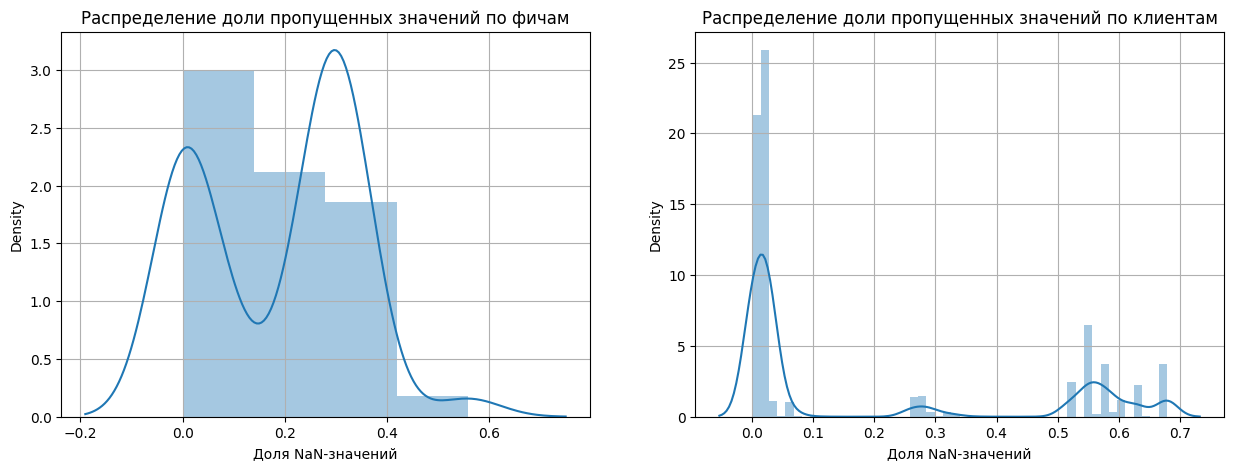

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.distplot(train_df[num_feat].isna().mean(axis=0), ax=ax[0])
ax[0].set_title('Распределение доли пропущенных значений по фичам')
ax[0].set_xlabel('Доля NaN-значений')
ax[0].grid(True)

sns.distplot(train_df[num_feat].isna().mean(axis=1), ax=ax[1])
ax[1].set_title('Распределение доли пропущенных значений по клиентам')
ax[1].set_xlabel('Доля NaN-значений')
ax[1].grid(True)

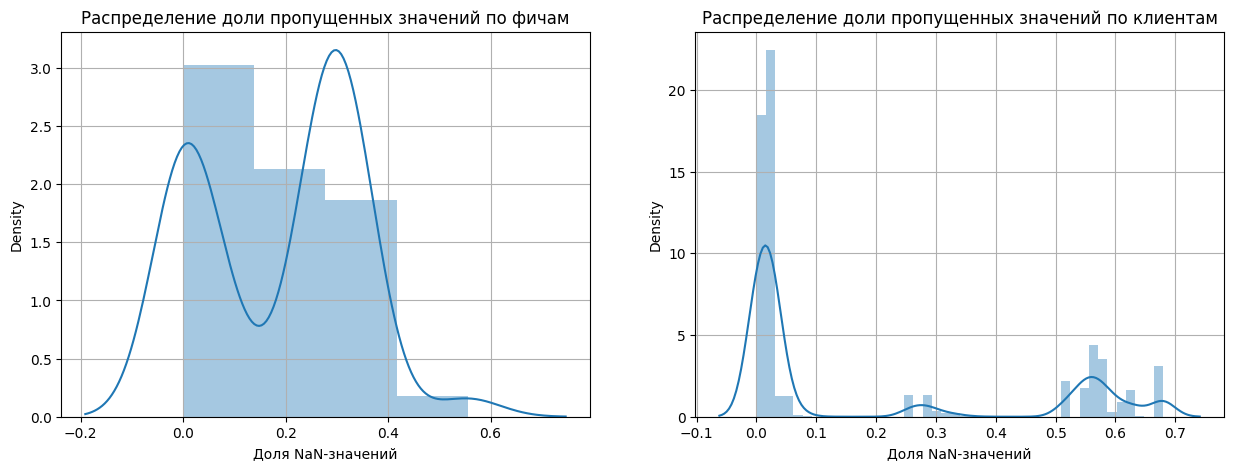

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.distplot(test_df[num_feat].isna().mean(axis=0), ax=ax[0])
ax[0].set_title('Распределение доли пропущенных значений по фичам')
ax[0].set_xlabel('Доля NaN-значений')
ax[0].grid(True)

sns.distplot(test_df[num_feat].isna().mean(axis=1), ax=ax[1])
ax[1].set_title('Распределение доли пропущенных значений по клиентам')
ax[1].set_xlabel('Доля NaN-значений')
ax[1].grid(True)

Доля пропущенных значений в фичах не превышает 70%, не имеет смысла отрезать фичи по пропущенным значениям. Доля людей с мало заполненными фичами также незначительна. Однако есть распределение по заполненности фичей среди людей, возможно, это ценная информация

Выделим фичи, которые мало влияют на датфрейм

In [18]:
# по доле самого частого значения

def feats_filter_nunique(df: pd.DataFrame,
                         features: list,
                         unique_threshold: float):

    # Создаем пустой список для хранения фичей
    frq_features = []

    for feat in features:
        # подсчет уникальных значений
        unique_values = df[feat].nunique()

        # Проверка на то, что у фичи только одно уникальное значение
        # Или доля самого частого значения (включая NaN) меньше порога
        if unique_values > 1:
          value_counts_1 = df[feat].value_counts(dropna=False)
          most_common_value_ratio = value_counts_1.iloc[0] / len(df)
          if most_common_value_ratio > unique_threshold:
            frq_features.append(feat)


    return frq_features  # Возвращаем список


freq_features = feats_filter_nunique(train_df, num_feat, 0.98)
len(freq_features)

1

In [19]:
freq_features

['sum_b_oper_1m']

In [20]:
# по корреляции

def feats_filter_corr(df: pd.DataFrame,
                      features: list,
                      corr_threshold: float):


    corr_features = set()


    #вычисляем матрицу корреляции между всеми парами фичей
    corr_matrix = df[features].corr(method = 'pearson', min_periods = 1, numeric_only = True)

    #проходим по матрице корреляции, ищем коррелирующие фичи и выбираем для выброса менее заполненную
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= corr_threshold:
              if df[corr_matrix.columns[i]].count() <=  df[corr_matrix.columns[j]].count():
                corr_features.add(corr_matrix.columns[i])
              else:
                corr_features.add(corr_matrix.columns[j])

    return corr_features

correlated_features = feats_filter_corr(train_df, num_feat, 0.98)
len(correlated_features)

8

In [21]:
correlated_features

{'balance_amt_day_avg',
 'cnt_cred_e_oper_1m',
 'cnt_cred_f_oper_1m',
 'cnt_deb_e_oper_1m',
 'cnt_deb_f_oper_1m',
 'ogrn_exist_months',
 'sum_cred_e_oper_3m',
 'sum_cred_g_oper_3m'}

Пройдем по важным категориальным фичам, убедимся, что они все зашифрованы. Никакие сторонние данные использовать не представляется возможным

In [ ]:
train_df['index_city_code'].nunique(), train_df['city'].nunique(), train_df['city_type'].nunique()

(233, 8917, 7931)

In [ ]:
train_df['ogrn_year'].unique()

array(['ogrn_year_1', 'ogrn_year_15', 'ogrn_year_19', 'ogrn_year_10',
       'ogrn_year_20', None, 'ogrn_year_16', 'ogrn_year_2',
       'ogrn_year_18', 'ogrn_year_9', 'ogrn_year_5', 'ogrn_year_11',
       'ogrn_year_4', 'ogrn_year_14', 'ogrn_year_12', 'ogrn_year_6',
       'ogrn_year_7', 'ogrn_year_3', 'ogrn_year_8', 'ogrn_year_0',
       'ogrn_year_13', 'ogrn_year_17'], dtype=object)

In [ ]:
train_df['ogrn_month'].unique()

array(['ogrn_month_0', 'ogrn_month_5', 'ogrn_month_9', 'ogrn_month_4',
       None, 'ogrn_month_3', 'ogrn_month_8', 'ogrn_month_10',
       'ogrn_month_7', 'ogrn_month_11', 'ogrn_month_2', 'ogrn_month_6',
       'ogrn_month_1'], dtype=object)

In [11]:
# Подсчет числа заполненных значений в каждой строке
# не запускать, если хотим только на исходных фичах считать

train_df['filled_cols'] = train_df.drop(['id', 'date', 'start_cluster', 'end_cluster'], axis=1).count(axis=1)
test_df['filled_cols'] = test_df.drop(['id', 'date', 'start_cluster'], axis=1).count(axis=1)

In [12]:
train_df['filled_cols'].describe()

count    600000.000000
mean         72.757053
std          21.532441
min          26.000000
25%          47.000000
50%          86.000000
75%          88.000000
max          89.000000
Name: filled_cols, dtype: float64

In [13]:
test_df['filled_cols'].describe()

count    290120.000000
mean         72.648711
std          21.368681
min          26.000000
25%          47.000000
50%          86.000000
75%          87.000000
max          89.000000
Name: filled_cols, dtype: float64

На трейне и тесте заполненность колонок распределена схожим образом, эту информацию можно использовать как дополнительную фичу в моделях

# Дрифт фичей

Посмотрим дрифт фичей с помощью библиотеки deepchecks

In [58]:
# Мало влияющие фичи не рассматриваем
drop_feat = list(set(freq_features).union(set(correlated_features)))
len(drop_feat)

9

In [59]:
selected_features = [x for x in feat if x not in drop_feat]
len(selected_features)

82

In [60]:
selected_features_num = [feat for feat in num_feat if feat in selected_features]
selected_features_cat = [feat for feat in cat_feat if feat in selected_features]
len(selected_features_num), len(selected_features_cat)

(72, 10)

In [ ]:
train_dd = Dataset(
    train_df,
    cat_features=selected_features_cat,
    features=selected_features
)
test_dd = Dataset(
    test_df,
    cat_features=selected_features_cat,
    features=selected_features
)

check = FeatureDrift(categorical_drift_method = 'PSI', n_top_columns = 15)
check_result = check.run(train_dataset=train_dd, test_dataset=test_dd)

In [ ]:
check_result

<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Feature Drift

Существенно отличается на трейне и тесте только фича date, что связано с видом датафреймов. Эта фича не участвует в обучении моделей. Остальные фичи распределены похожим образом на трейне и тесте.

IndexError: index 7 is out of bounds for axis 0 with size 7

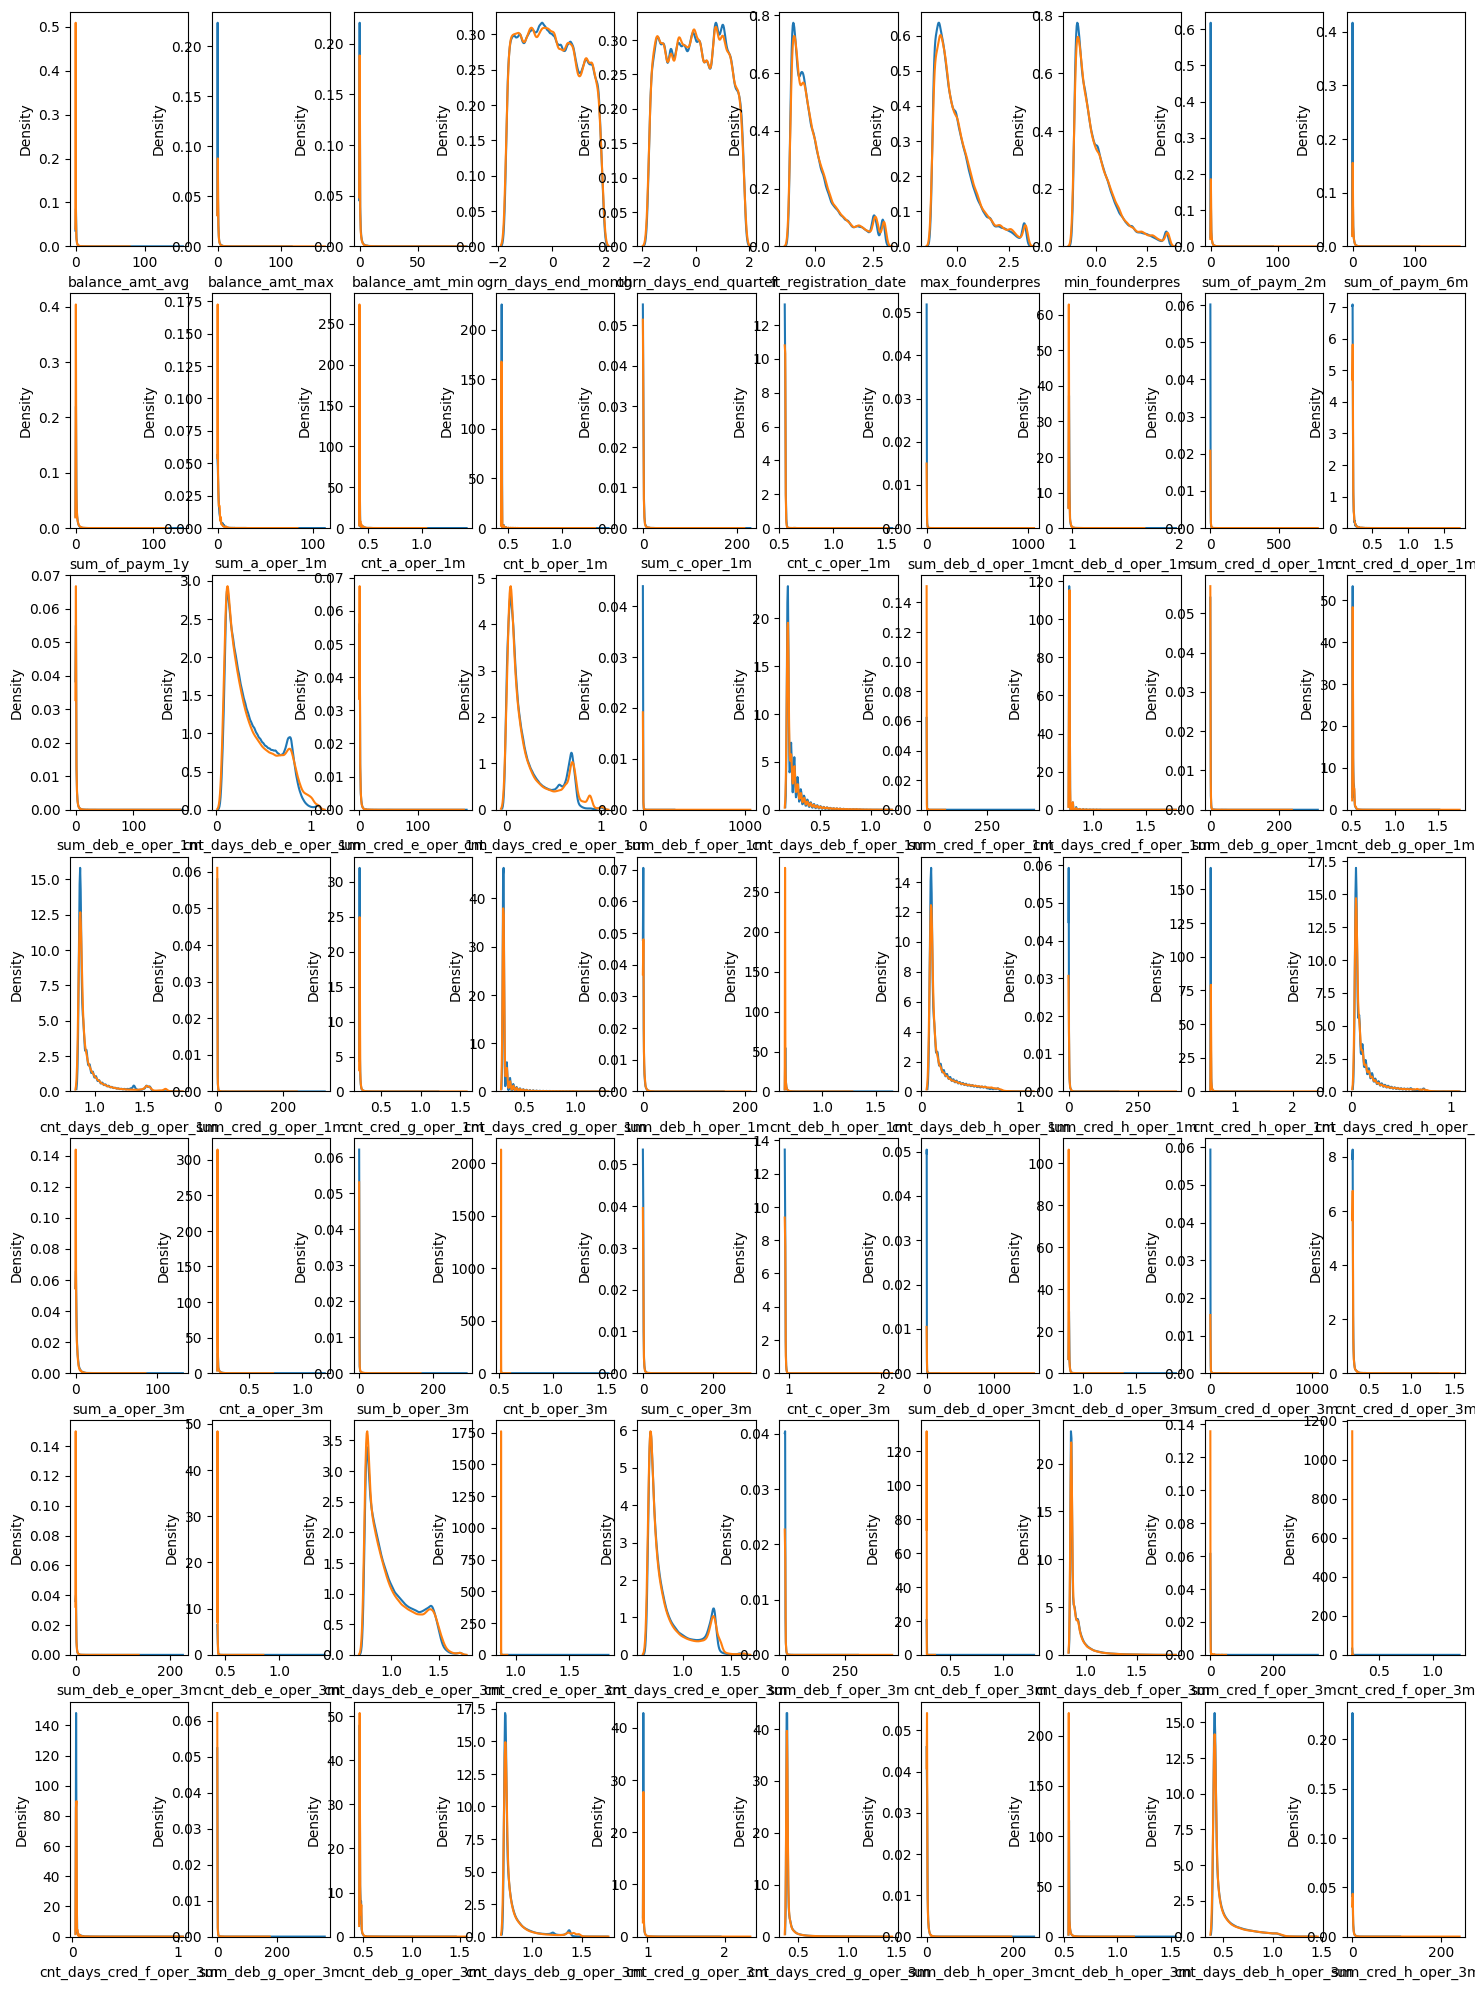

In [28]:
fig, axes = plt.subplots(7, 10, figsize=(18, 25))
i = 0
for feature in selected_features_num:
    ax = axes[i // 10, i % 10]
    sns.kdeplot(train_df[feature], ax=ax, label="Train")
    sns.kdeplot(test_df[feature], ax=ax, label="Test")
    i += 1
fig.tight_layout()

Фичи на трейне и тесте распределены очень похожим образом

# Исследование кластеров

Посмотрим, сколько записей, соответствующих разным начальным кластерам есть в трейне

In [29]:
# Создание DataFrame claster_df из train_df
cluster_df = train_df[['start_cluster', 'end_cluster']]

In [30]:
# Создаем словарь уникальных значений start_cluster и их частот
start_cluster_counts = train_df['start_cluster'].value_counts().to_dict()
start_cluster_counts

{'{α}': 375947,
 '{}': 78803,
 '{α, η}': 43824,
 '{α, γ}': 32790,
 '{other}': 31813,
 '{α, β}': 9869,
 '{α, δ}': 8537,
 '{α, ε}': 5843,
 '{α, θ}': 4968,
 '{α, ψ}': 3000,
 '{α, μ}': 1341,
 '{α, ε, η}': 1207,
 '{α, ε, θ}': 851,
 '{α, λ}': 739,
 '{α, ε, ψ}': 374,
 '{λ}': 69,
 '{α, π}': 25}

Видим, что в исходных данных более половины стартовых кластеров в трейне это альфа. В целом видно следующее:
1. Первые пять кластеров в списке имеют достаточно данных для разработки независимых моделей (можно попробовать создать отдельные модели для этих кластеров)
2. Последние пять имеют очень мало данных, даже в рамках общих моделей что-то определенное для них сказать будет сложно
3. Кластеры посередине могут быть предсказаны плохо или хорошо в зависимости от качества модели и того, насколько много данных ей нужно для нормального обучения

Посмотрим на конечные кластеры

In [31]:
end_cluster_counts = cluster_df['end_cluster'].value_counts().to_dict()
end_cluster_counts

{'{α}': 318670,
 '{}': 122366,
 '{other}': 47197,
 '{α, η}': 40810,
 '{α, γ}': 34471,
 '{α, β}': 11203,
 '{α, θ}': 6511,
 '{α, ε}': 5450,
 '{α, δ}': 4078,
 '{α, ψ}': 2929,
 '{α, μ}': 2123,
 '{α, ε, η}': 1674,
 '{α, ε, θ}': 1125,
 '{α, λ}': 873,
 '{α, ε, ψ}': 361,
 '{λ}': 140,
 '{α, π}': 19}

Распределение конечных кластеров похоже на распределение стартовых кластеров. Можно предположить в нулевом приближении, что конечный кластер просто равен первым трем-пяти в списке или начальному

Посмотрим на тест

In [32]:
cluster_test_df = test_df['start_cluster']

In [33]:
# Создаем словарь уникальных значений start_cluster и их частот
start_cluster_counts_test = test_df['start_cluster'].value_counts().to_dict()
start_cluster_counts_test

{'{α}': 115245,
 '{}': 28269,
 '{α, η}': 13634,
 '{other}': 10732,
 '{α, γ}': 10339,
 '{α, β}': 3629,
 '{α, δ}': 2813,
 '{α, ε}': 1621,
 '{α, θ}': 1380,
 '{α, ψ}': 876,
 '{α, μ}': 542,
 '{α, ε, η}': 413,
 '{α, λ}': 258,
 '{α, ε, θ}': 232,
 '{α, ε, ψ}': 88,
 '{λ}': 45,
 '{α, π}': 4}

В целом распределение начальных кластеров схоже с трейном

# Матрица переходов start_cluster -> end_cluster

In [39]:
# Уникальные значения start_cluster
unique_start_clusters = cluster_df['start_cluster'].unique()
unique_start_clusters

array(['{α, γ}', '{other}', '{α}', '{}', '{α, ε, ψ}', '{α, δ}', '{α, η}',
       '{α, β}', '{α, ε, η}', '{α, μ}', '{α, ψ}', '{α, λ}', '{α, ε}',
       '{α, ε, θ}', '{α, θ}', '{λ}', '{α, π}'], dtype=object)

In [41]:
# Создание матрицы, в которую запишем сколько раз встречается данный конечный кластер для каждого начального
matrix = cluster_df.groupby(['start_cluster', 'end_cluster']).size().unstack(fill_value=0)

matrix

end_cluster,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
start_cluster,,,,,,,,,,,,,,,,,
{other},21600,292,566,3941,272,94,143,73,407,973,731,72,173,0,400,2066,10
{},2494,42757,500,1364,133,90,41,5,301,3213,393,37,153,0,120,27185,17
"{α, β}",1114,172,4817,184,52,4,5,0,47,40,44,1,8,0,10,3370,1
"{α, γ}",5596,665,113,20702,49,7,9,5,59,72,74,12,22,0,30,5375,0
"{α, δ}",615,323,220,249,1804,3,12,0,60,25,46,11,32,0,14,5123,0
"{α, ε, η}",254,22,0,3,1,598,8,3,130,123,2,0,1,0,0,62,0
"{α, ε, θ}",215,7,9,7,3,0,270,0,58,3,197,0,0,0,0,82,0
"{α, ε, ψ}",98,5,0,0,2,0,2,129,20,0,0,0,0,0,90,28,0
"{α, ε}",874,243,54,113,44,55,186,21,2302,35,94,6,25,0,26,1765,0


In [42]:
# Проход по start_cluster и деление значений в матрице на соответствующее количество
for start_cluster in unique_start_clusters:
    matrix.loc[start_cluster] /= start_cluster_counts[start_cluster]

Получили матрицу вероятности переходов из начального кластера в конечный, посчитанную "в лоб"
Для редких кластеров таким образом определенные вероятности, возможно, будут точнее модельных

In [43]:
matrix

end_cluster,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
start_cluster,,,,,,,,,,,,,,,,,
{other},0.678968,0.009179,0.017791,0.123880,0.008550,0.002955,0.004495,0.002295,0.012794,0.030585,0.022978,0.002263,0.005438,0.000000,0.012573,0.064942,0.000314
{},0.031649,0.542581,0.006345,0.017309,0.001688,0.001142,0.000520,0.000063,0.003820,0.040773,0.004987,0.000470,0.001942,0.000000,0.001523,0.344974,0.000216
"{α, β}",0.112879,0.017428,0.488094,0.018644,0.005269,0.000405,0.000507,0.000000,0.004762,0.004053,0.004458,0.000101,0.000811,0.000000,0.001013,0.341473,0.000101
"{α, γ}",0.170662,0.020281,0.003446,0.631351,0.001494,0.000213,0.000274,0.000152,0.001799,0.002196,0.002257,0.000366,0.000671,0.000000,0.000915,0.163922,0.000000
"{α, δ}",0.072039,0.037835,0.025770,0.029167,0.211315,0.000351,0.001406,0.000000,0.007028,0.002928,0.005388,0.001289,0.003748,0.000000,0.001640,0.600094,0.000000
"{α, ε, η}",0.210439,0.018227,0.000000,0.002486,0.000829,0.495443,0.006628,0.002486,0.107705,0.101906,0.001657,0.000000,0.000829,0.000000,0.000000,0.051367,0.000000
"{α, ε, θ}",0.252644,0.008226,0.010576,0.008226,0.003525,0.000000,0.317274,0.000000,0.068155,0.003525,0.231492,0.000000,0.000000,0.000000,0.000000,0.096357,0.000000
"{α, ε, ψ}",0.262032,0.013369,0.000000,0.000000,0.005348,0.000000,0.005348,0.344920,0.053476,0.000000,0.000000,0.000000,0.000000,0.000000,0.240642,0.074866,0.000000
"{α, ε}",0.149581,0.041588,0.009242,0.019339,0.007530,0.009413,0.031833,0.003594,0.393976,0.005990,0.016088,0.001027,0.004279,0.000000,0.004450,0.302071,0.000000


In [44]:
#Создание словаря, где каждому значению из unique_start_clusters сопоставляем значение
#из end_cluster с максимальным значением в строке

max_end_cluster_values = matrix.idxmax(axis=1).to_dict()

In [45]:
max_end_cluster_values

{'{other}': '{other}',
 '{}': '{}',
 '{α, β}': '{α, β}',
 '{α, γ}': '{α, γ}',
 '{α, δ}': '{α}',
 '{α, ε, η}': '{α, ε, η}',
 '{α, ε, θ}': '{α, ε, θ}',
 '{α, ε, ψ}': '{α, ε, ψ}',
 '{α, ε}': '{α, ε}',
 '{α, η}': '{α, η}',
 '{α, θ}': '{α, θ}',
 '{α, λ}': '{α, λ}',
 '{α, μ}': '{α, μ}',
 '{α, π}': '{other}',
 '{α, ψ}': '{α, ψ}',
 '{α}': '{α}',
 '{λ}': '{α, λ}'}

Таким образом, наиболее вероятные конечные кластеры для всех начальных кластеров таковы:

In [ ]:
clusters = {'{other}': '{other}',
 '{}': '{}',
 '{α, β}': '{α, β}',
 '{α, γ}': '{α, γ}',
 '{α, δ}': '{α}',
 '{α, ε, η}': '{α, ε, η}',
 '{α, ε, θ}': '{α, ε, θ}',
 '{α, ε, ψ}': '{α, ε, ψ}',
 '{α, ε}': '{α, ε}',
 '{α, η}': '{α, η}',
 '{α, θ}': '{α, θ}',
 '{α, λ}': '{α, λ}',
 '{α, μ}': '{α, μ}',
 '{α, π}': '{other}',
 '{α, ψ}': '{α, ψ}',
 '{α}': '{α}',
 '{λ}': '{α, λ}'}

Эту информацию можно использовать в качестве начального преположения о распределении вероятностей или в качестве дополнительной фичи

Полученную здесь информацию использовали для построения моделей

Также в ходе решения использовали заполнение пропусков в числовых фичах нулями для Catboost и не заполняли для LGBMBoost.
В качестве предположения о стартовом кластере в month_6 использовали информацию о стартовом кластере на month_5. Была идея разработать отдельную модель для определения стартового кластера, но выяснилось, что лишь 20% клиентов из трейнового датасета изменяют кластер на горизонте трех месяцев, эта идея была сочтена не приорететной и до ее реализации за время хакатона, к сожалению, не добрались. Однако она кажется перспективной